In [1]:
# import modules

import numpy as np

from prospect.io import read_results as pr
from dynesty import plotting as dyplot

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'


In [2]:
# define paths

path_main = '/Users/sandrotacchella/ASTRO/JWST/Proposal_GO_Cycle1/spec_vs_phot/results/'

path_figure = '/Users/sandrotacchella/ASTRO/JWST/Proposal_GO_Cycle1/figures/'


In [3]:
# define functions

def zfrac_to_masses(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to sfr
    fractions and then to bin mass fractions. The transformation is such that
    sfr fractions are drawn from a Dirichlet prior.  See Betancourt et al. 2010

    :returns masses:
        The stellar mass formed in each age bin.
    """
    # sfr fractions (e.g. Leja 2016)
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])

    # convert to mass fractions
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    sfr_fraction *= np.array(time_per_bin)
    sfr_fraction /= sfr_fraction.sum()

    masses = total_mass * sfr_fraction
    return masses


In [4]:
# read in results

res, obs, mod = pr.results_from(path_main + 'mock_svp_1_1522120237_mcmc.h5', dangerous=True)
sps = pr.get_sps(res)
mod._config_dict["mass"]["depends_on"] = zfrac_to_masses


Could not check SSP library versions.


In [5]:
mod.theta_labels()

['total_mass',
 'z_fraction_1',
 'z_fraction_2',
 'z_fraction_3',
 'z_fraction_4',
 'logzsol',
 'dust2',
 'gas_logu',
 'sigma_smooth']

In [6]:
ndim = len(mod.theta_labels())

In [7]:
res['run_params']

{u'add_neb_emission': False,
 u'agelims': [0.0, 7.3, 8.0, 8.5, 9.0, 9.5],
 u'debug': False,
 u'i_comp': 1.0,
 u'infile_phot': u'data/example_mags.txt',
 u'infile_spec': u'data/example_spectra_with_noise.txt',
 u'logify_spectrum': False,
 u'mask_elines': True,
 u'nested_bound': u'multi',
 u'nested_dlogz_init': 0.01,
 u'nested_nlive_batch': 100,
 u'nested_nlive_init': 100,
 u'nested_sample': u'rslice',
 u'nested_slices': 6,
 u'nested_stop_kwargs': {u'n_mc': 50, u'post_thresh': 0.05},
 u'nested_weight_kwargs': {u'pfrac': 1.0},
 u'normalize_spectrum': False,
 u'outfile': u'/n/home03/stacchella/proposals/spec_vs_phot//results/mock_svp_1',
 u'param_file': u'/n/home03/stacchella/proposals/spec_vs_phot//nonparametric_spec_fitting.py',
 u'phot': False,
 u'polyorder': 0,
 u'rescale_spectrum': False,
 u'spec': True,
 u'sps_libraries': [u'mist', u'miles'],
 u'sys.argv': [u'/n/home03/stacchella/programs//prospector/scripts/prospector_dynesty.py',
  u'--param_file=/n/home03/stacchella/proposals/spec

In [8]:
res

{u'chain': array([[ 3.77516304e+11,  3.11185156e-01,  7.14792912e-01, ...,
          5.91167135e-01, -2.79964206e+00,  1.94639070e+02],
        [ 6.20851141e+11,  9.99253861e-01,  9.58328317e-01, ...,
          4.41931603e-01, -1.00207617e+00,  2.43943712e+02],
        [ 9.79770193e+11,  6.57260791e-01,  8.64576632e-01, ...,
          8.68338997e-01, -3.08143979e+00,  1.96573964e+02],
        ...,
        [ 9.03988633e+10,  9.97369722e-01,  9.99886231e-01, ...,
          5.19700846e-01, -2.52194992e+00,  1.00326911e+02],
        [ 9.06784489e+10,  9.97969332e-01,  9.99807079e-01, ...,
          5.21311406e-01, -2.53910663e+00,  1.00270102e+02],
        [ 9.06938108e+10,  9.98101190e-01,  9.99976247e-01, ...,
          5.21905834e-01, -2.53023698e+00,  1.00275091e+02]]),
 u'efficiency': array([3.92935078]),
 u'information': array([ 5.28050372,  5.79548675,  5.09171098, ..., 51.52894087,
        51.52957181, 51.53034901]),
 u'lnlikelihood': array([-9.55029898e+07, -8.41824422e+07, -7.227

In [10]:
# find best fit

ind = res['lnprobability'].argmax()
print ind
theta_max = res['chain'][ind]
print theta_max

spec, phot, x = mod.mean_model(theta_max, obs=obs, sps=sps)


8246
[ 9.06938108e+10  9.98101190e-01  9.99976247e-01  9.99835966e-01
  9.99555911e-01 -2.50185834e-04  5.21905834e-01 -2.53023698e+00
  1.00275091e+02]


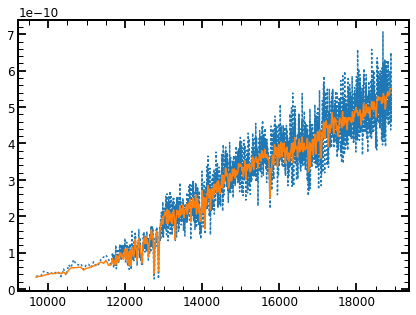

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(7.0, 5.0))
#axes.plot(obs['wavelength'], -2.5*np.log10(obs['spectrum']), '-')

axes.plot(obs['wavelength'], obs['spectrum'], ':')
axes.plot(obs['wavelength'], spec)

#axes.set_xlim([13225, 13375])
#axes.set_ylim([-1.2, 2.2])

#axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mathrm{\AA}]$', fontsize=18)
#axes.set_ylabel(r'$\mathrm{flux}\/\/\/[\mathrm{arb.\/units}]$', fontsize=18)
# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()

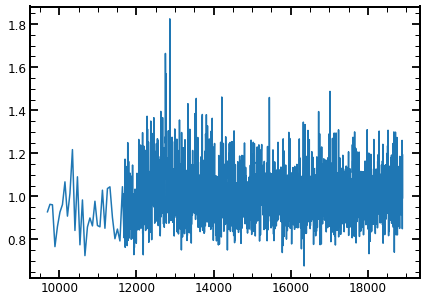

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(7.0, 5.0))
#axes.plot(obs['wavelength'], -2.5*np.log10(obs['spectrum']), '-')

axes.plot(obs['wavelength'], spec/obs['spectrum'])

#axes.set_xlim([13225, 13375])
#axes.set_ylim([-1.2, 2.2])

#axes.set_xlabel(r'$\lambda_{\rm obs}\/\/\/[\mathrm{\AA}]$', fontsize=18)
#axes.set_ylabel(r'$\mathrm{flux}\/\/\/[\mathrm{arb.\/units}]$', fontsize=18)
# plt.savefig(path_figure + 'investigate_resolution_spec.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [15]:
# transform to preferred model variables
#res['chain'], parnames = transform_chain(res['chain'], res['model'])

# mimic dynesty outputs
res['logwt'] = np.log(res['weights'])+res['logz'][-1]
res['logl'] = res['lnlikelihood']
res['samples'] = res['chain']

/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


In [16]:
lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res, lnz_truth=lnz_truth)  # summary (run) plot
plt.show()

KeyError: 'nlive'

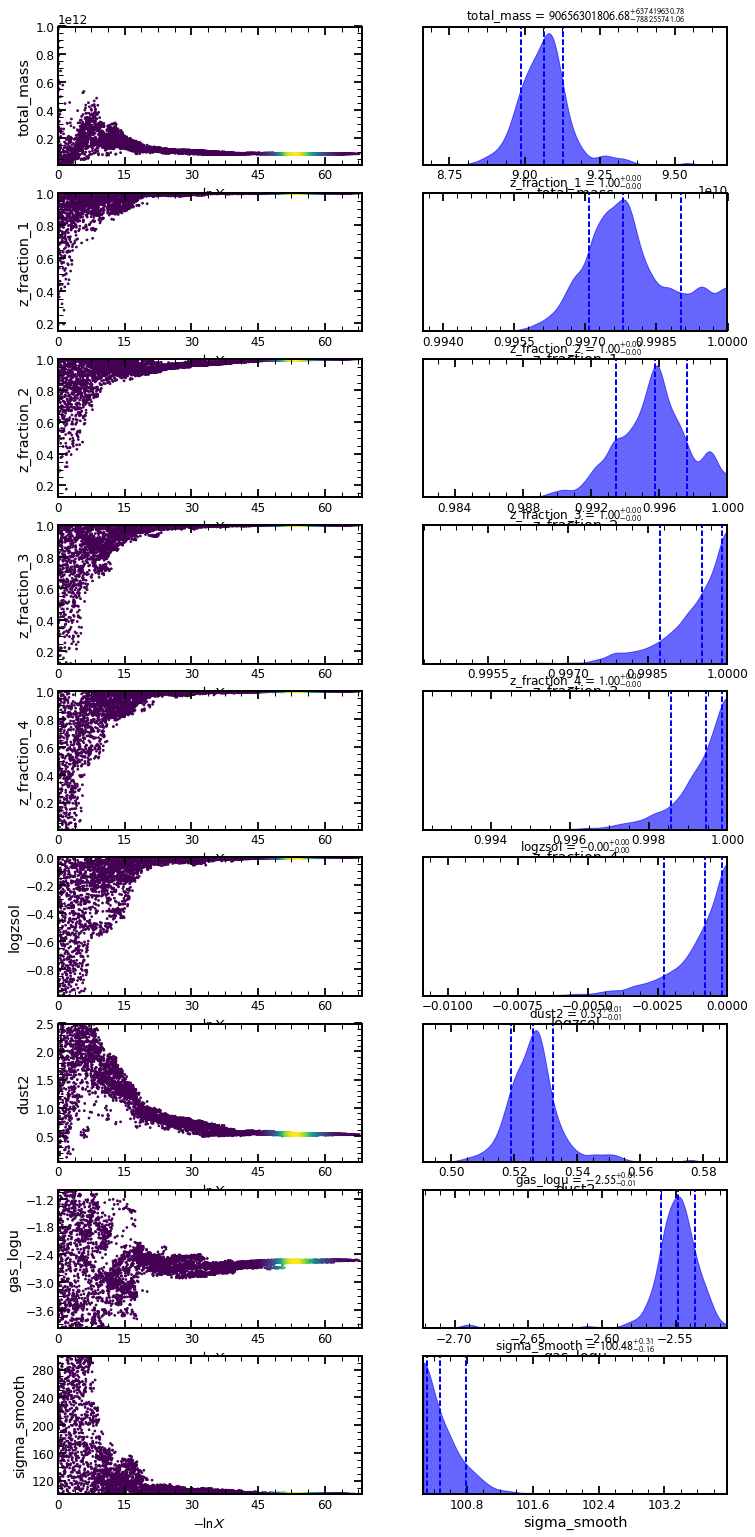

In [17]:
fig, axes = dyplot.traceplot(res, truths=np.zeros(ndim), labels=mod.theta_labels(),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=False)
                             #connect_highlight=range(5))
plt.show()

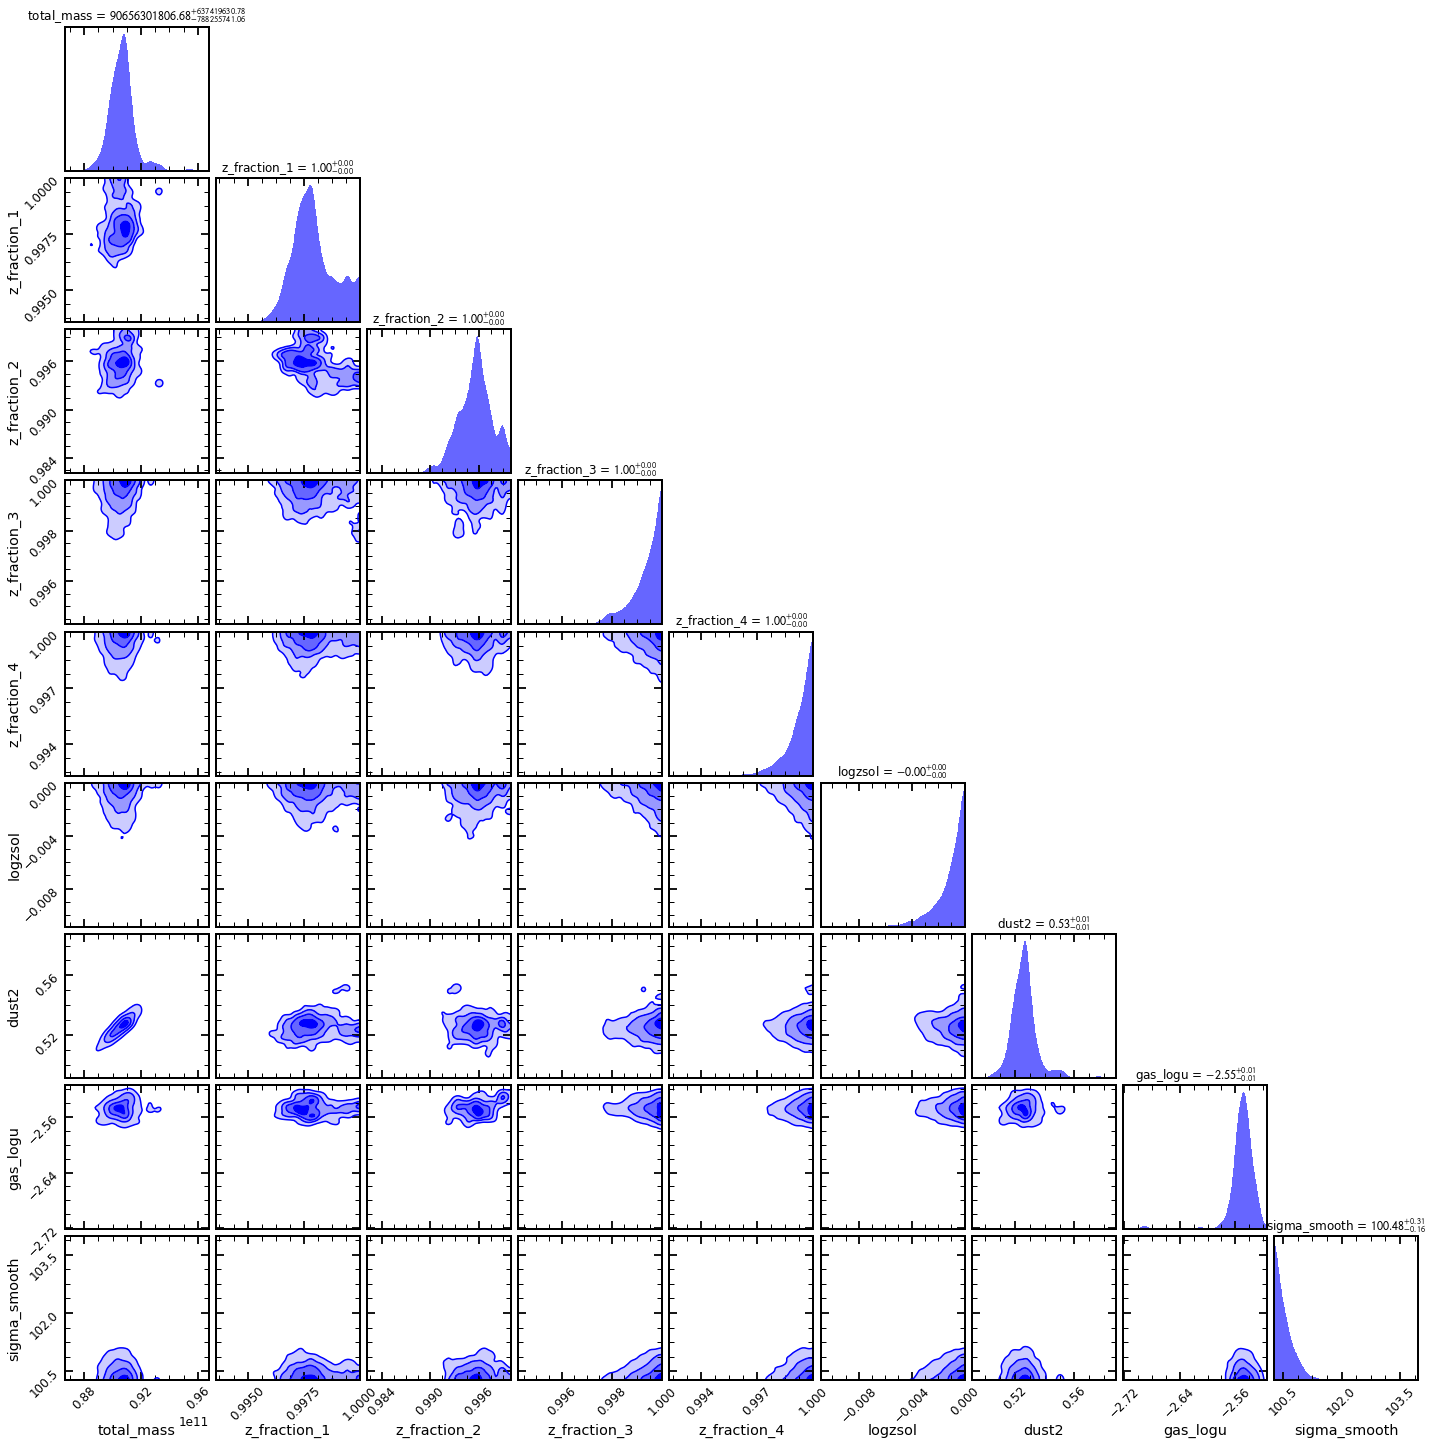

In [18]:
fg, ax = dyplot.cornerplot(res, color='blue', truths=np.zeros(ndim), labels=mod.theta_labels(),
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, quantiles=None)
plt.show()

In [ ]:
fig = pr.subtriangle

In [22]:
res['weights']

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       9.12184202e-05, 9.54596640e-05, 1.14307539e-04])

In [19]:
Mformed = zfrac_to_masses(total_mass=res['chain'][-1,0], z_fraction=res['chain'][-1,1:5], agebins=mod.params['agebins'])


In [20]:
Mformed/np.squeeze(np.diff(10**mod.params['agebins'], axis=1))

array([7.98309575e-02, 9.96735069e-04, 6.88317451e-03, 1.86317103e-02,
       4.19362932e+01])

In [21]:
np.diff(10**mod.params['agebins'], axis=1).shape

(5, 1)

In [26]:
10**np.array([0., 7.3, 8.0, 8.5, 9.0, 9.5])

array([1.00000000e+00, 1.99526231e+07, 1.00000000e+08, 3.16227766e+08,
       1.00000000e+09, 3.16227766e+09])

In [20]:
from dynesty import plotting as dyplot


import sys
sys.path.append('/Users/sandrotacchella/ASTRO/Programms/Python_Codes/')

import prosp_dutils
reload(prosp_dutils)


<module 'prosp_dutils' from '/Users/sandrotacchella/ASTRO/Programms/Python_Codes/prosp_dutils.py'>

In [18]:
res, powell_results, model, eout = prosp_dutils.load_prospector_data(path_main + 'mock_svp_1_1522120237', load_extra_output=False)


In [28]:
# transform to preferred model variables
res['chain'], parnames = prosp_dutils.transform_chain(res['chain'], res['model'])

# mimic dynesty outputs
res['logwt'] = np.log(res['weights'])+res['logz'][-1]
res['logl'] = res['lnlikelihood']
res['samples'] = res['chain']
res['nlive'] = res['run_params']['nested_nlive_batch']


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


making TRACE plot


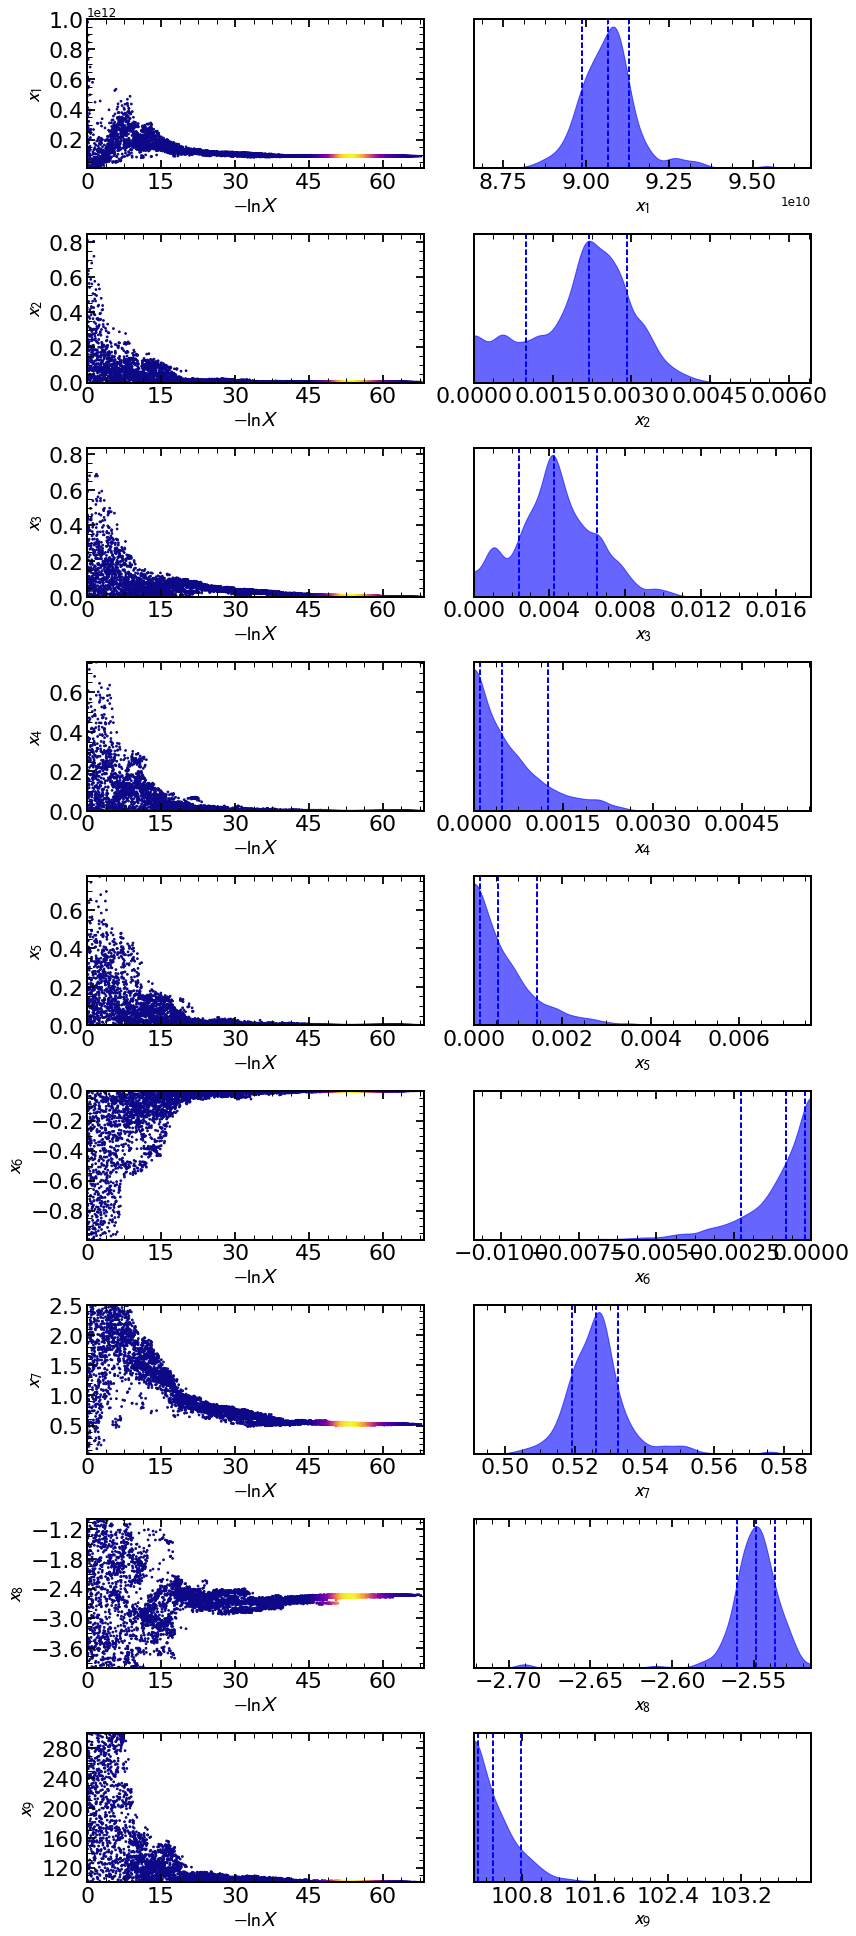

In [22]:
print 'making TRACE plot'
tfig, taxes = dyplot.traceplot(res, label_kwargs={'fontsize': 20})
for ax in taxes.ravel():
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
tfig.tight_layout()
plt.show()


making SUMMARY plot


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/dynesty-0.9.2b0-py2.7.egg/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/dynesty-0.9.2b0-py2.7.egg/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/dynesty-0.9.2b0-py2.7.egg/dynesty/plotting.py:274: RuntimeWarning: overflow encountered in exp


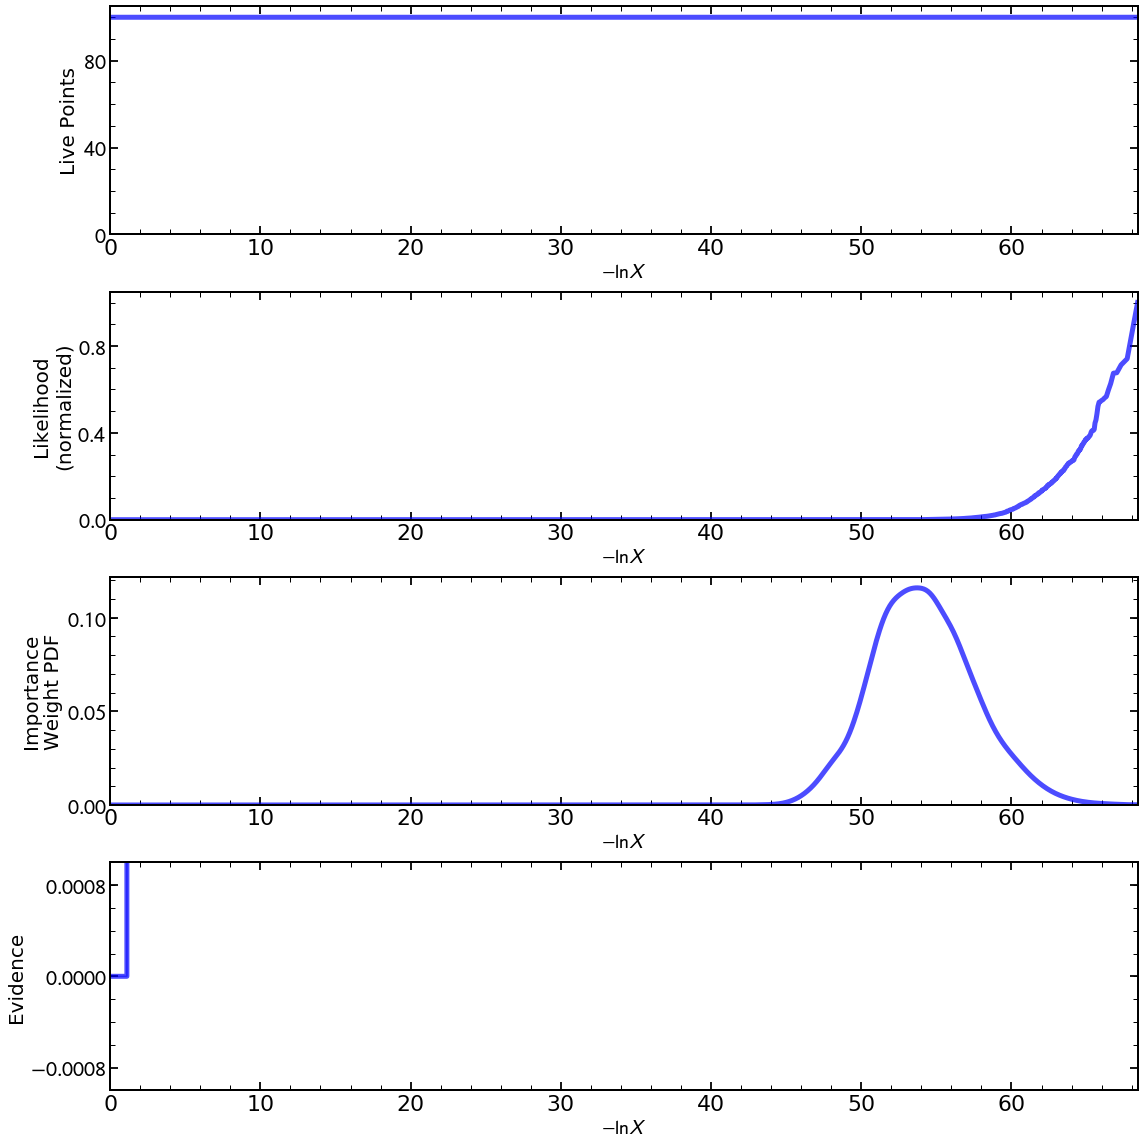

In [29]:
# Plot a summary of the run.
print 'making SUMMARY plot'
rfig, raxes = dyplot.runplot(res, mark_final_live=False, label_kwargs={'fontsize': 20})
for ax in raxes:
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    ax.yaxis.get_offset_text().set_size(20)
rfig.tight_layout()
plt.show()


In [27]:
res

{u'chain': array([[ 3.77516304e+11,  3.11185156e-01,  6.27681003e-01, ...,
          5.91167135e-01, -2.79964206e+00,  1.94639070e+02],
        [ 6.20851141e+11,  9.99253861e-01,  7.15069134e-04, ...,
          4.41931603e-01, -1.00207617e+00,  2.43943712e+02],
        [ 9.79770193e+11,  6.57260791e-01,  3.12232516e-01, ...,
          8.68338997e-01, -3.08143979e+00,  1.96573964e+02],
        ...,
        [ 9.03988633e+10,  9.97369722e-01,  2.62997917e-03, ...,
          5.19700846e-01, -2.52194992e+00,  1.00326911e+02],
        [ 9.06784489e+10,  9.97969332e-01,  2.03027658e-03, ...,
          5.21311406e-01, -2.53910663e+00,  1.00270102e+02],
        [ 9.06938108e+10,  9.98101190e-01,  1.89876451e-03, ...,
          5.21905834e-01, -2.53023698e+00,  1.00275091e+02]]),
 u'efficiency': array([3.92935078]),
 u'information': array([ 5.28050372,  5.79548675,  5.09171098, ..., 51.52894087,
        51.52957181, 51.53034901]),
 u'lnlikelihood': array([-9.55029898e+07, -8.41824422e+07, -7.227